# ANOVA de un factor

## 1. Cargar base de datos
### *Lista con los nombres de las variables del dataframe

In [1]:
import pandas as pd
from sklearn.datasets import load_iris

iris_names = load_iris()
names = iris_names['feature_names']
names.append('class')

### *Construcción del dataframe

In [2]:
data, target = load_iris(return_X_y=True)
data = pd.DataFrame(data)
target = pd.DataFrame(target)
iris = pd.concat([data, target], axis=1)
iris.columns = names
iris['class'].replace({0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}, inplace = True)
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,Iris-Setosa
1,4.9,3.0,1.4,0.2,Iris-Setosa
2,4.7,3.2,1.3,0.2,Iris-Setosa
3,4.6,3.1,1.5,0.2,Iris-Setosa
4,5.0,3.6,1.4,0.2,Iris-Setosa


## 2. Test de normalidad

### Hipótesis:
$$\begin{cases} { H }_{ 0 }: la \quad variable \quad procede \quad de \quad una \quad distribución \quad normal \\ { H }_{ 1 }: la \quad variable \quad no \quad procede \quad de \quad una \quad distribución \quad normal\end{cases}$$

In [3]:
from scipy import stats
p_values = pd.DataFrame(stats.normaltest(iris.iloc[:, :-1]).pvalue ,index = names[:-1]).T
p_values.style.applymap(lambda x: 'background-color : lightgreen' if x>=0.05 else 'background-color : salmon')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.0568242,0.167241,8.67787e-49,1.99181e-30


En verde los valores estadísticamente no significativos ($p-valor \ge 0.05$) y en rojo los valores estadísticamente significativos ($p-valor<0.05$)

## 3. ANOVA de un factor
Es una técnica paramétrica en la que se intenta comparar las medias de tres o más grupos. Al ser una técnica paramétrica es necesario que se cumplan ciertos supuestos para que el p-valor asociado sea válido:
 1. Independencia. Las muestras deben ser independientes.
 2. Normalidad. Cada muestra debe provenir de una población normalmente distribuida.
 3. Homocedasticidad. Las desviaciones estándar de los grupos deben ser iguales.

### 3.1 Revisión de supuestos estadísticos

##### Independencia
Se conoce de antemano que las muestras recogidas en los tres grupos son independientes. 

##### Normalidad

In [4]:
print ('Setosa: ' + str(stats.normaltest(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa']).pvalue))
print ('Versicolour: ' + str(stats.normaltest(iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour']).pvalue))
print ('Virginica: ' + str(stats.normaltest(iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica']).pvalue))

Setosa: 0.388916654112468
Versicolour: 0.48409071097159273
Virginica: 0.2770869880114645


Para cada grupo se acepta la hipótesis nula de que la distribución es normal

##### Homocedasticidad
Para demostrar la homocedasticidad se calculan los intervalos de confianza para las varianzas poblacionales de cada grupo. Si los intervalos se intersectan se considera que las varianzas son iguales. <br>
El intervalo de confianza para $\sigma^2$ (si se desconoce $\mu$) se calcula mediante la siguiente expresión:
$$IC=\left[ \frac { (n-1){ S }^{ 2 } }{ { x }_{ n-1,1-\alpha /2 }^{ 2 } } ,\frac { (n-1){ S }^{ 2 } }{ { x }_{ n-1,\alpha /2 }^{ 2 } }  \right] $$

In [5]:
import numpy as np
from scipy import stats

def IC_var(data, confidence=0.95):
    n = len(data)
    var = round(data.var(), 4)
    chi1, chi2 = stats.chi2.ppf((1-confidence)/2, n-1), stats.chi2.ppf(((1+confidence)/2), n-1)
    IC1 = round((n-1)*var/chi2, 4)
    IC2 = round((n-1)*var/chi1, 4)
    
    return  IC1, IC2

In [6]:
print('class_0: ' + str(IC_var(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa'])) ) 
print('class_1: ' + str(IC_var(iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour'])) ) 
print('class_2: ' + str(IC_var(iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica'])) ) 

class_0: (0.1013, 0.2255)
class_1: (0.0687, 0.153)
class_2: (0.0726, 0.1615)


In [171]:
IC_var_setosa = IC_var(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa'])
IC_var_versicolor = IC_var(iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour'])
IC_var_virginica = IC_var(iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica'])

intervalos_var = pd.DataFrame([IC_var_setosa, IC_var_versicolor, IC_var_virginica])
clase = pd.DataFrame(['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica'])

ic_var = pd.concat([intervalos_var, clase], axis=1)
ic_var.columns = ['LI', 'LS', 'class']
ic_var

,LI,LS,class
0,0.1013,0.2255,Iris-Setosa
1,0.0687,0.1530,Iris-Versicolour
2,0.0726,0.1615,Iris-Virginica


In [ ]:
import matplotlib.pyplot as plt

def IC_plot(X):
    xmin = min(X.iloc[:,0])
    xmax = max(X.iloc[:,1])
    
    i=0
    colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    for random in enumerate(X.index):
        plt.scatter(X.iloc[i,0], i+1, marker='|', s=500, c=colors[i])
        plt.scatter(X.iloc[i,1], i+1, marker='|', s=500, c=colors[i])
        i=i+1
    
    cur_axes = plt.gca()
    cur_axes.axes.get_yaxis().set_ticklabels([])
    cur_axes.axes.get_yaxis().set_ticks((X.index+1).tolist())
    
    plt.yticks((X.index+1).tolist(), X.iloc[:,2])
    plt.ylim(0.5, max(X.index)+1.5)

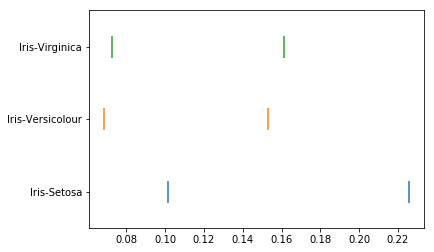

In [172]:
IC_plot(ic_var)

Como los intervalos se intersectan se pueden considerar que las varianzas de los tres grupos son iguales

### Como se cumplen los tres supuestos, es posible realizar un ANOVA para detectar si existe diferencia entre los tipos de flores.

#### Hipótesis:
$$\begin{cases} { H }_{ 0 }: { \mu  }_{ i }={ \mu  }_{ j } \\ { H }_{ 1 }: { \mu  }_{ i }\neq { \mu  }_{ j } \end{cases} \forall i\neq j$$

Se realiza la ANOVA para encontrar diferencia en el ancho del sépalo ("sepal width (cm)") entre las tres clases de flores

In [7]:
stats.f_oneway(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa'], 
              iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour'],
              iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica']).pvalue

1.3279165184572242e-16

Se rechaza la hipótesis nula, por lo tanto, al menos una de las medias de los grupos es distinta

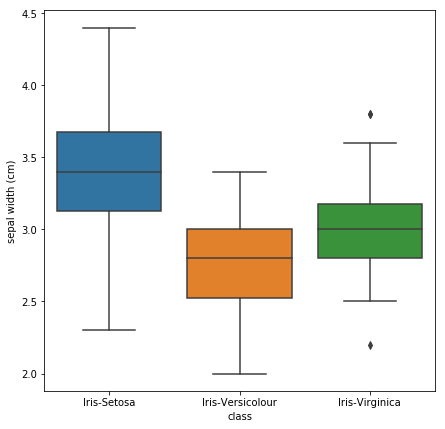

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,7))
sns.boxplot(x="class", y="sepal width (cm)", data=iris)

In [9]:
import numpy as np
from scipy import stats

def IC_mean(data, confidence=0.95):
    n = len(data)
    m, se = data.mean(), data.sem()
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return round(m-h,4), round(m+h,4)

In [10]:
print(IC_mean(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa']))
print(IC_mean(iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour']))
print(IC_mean(iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica']))

(3.3097, 3.5263)
(2.6808, 2.8592)
(2.8823, 3.0657)


In [151]:
setosa = IC_mean(iris['sepal width (cm)'][iris['class'] == 'Iris-Setosa'])
versicolor = IC_mean(iris['sepal width (cm)'][iris['class'] == 'Iris-Versicolour'])
virginica = IC_mean(iris['sepal width (cm)'][iris['class'] == 'Iris-Virginica'])

intervalos = pd.DataFrame([setosa, versicolor, virginica])
clase = pd.DataFrame(['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica'])

ic_media = pd.concat([intervalos, clase], axis=1)
ic_media.columns = ['LI', 'LS', 'class']
ic_media

,LI,LS,class
0,3.3097,3.5263,Iris-Setosa
1,2.6808,2.8592,Iris-Versicolour
2,2.8823,3.0657,Iris-Virginica


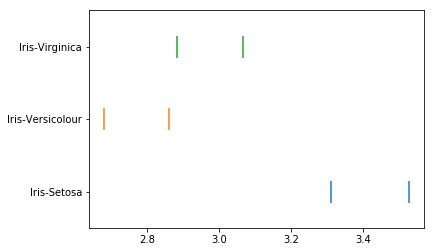

In [170]:
IC_plot(ic_media)

### Ningún intervalo se intersecta, por lo tanto, los tres grupos tienen medias distintas
Iris-Setosa tiene la media del ancho del sépalo más alta, mientas que Iris-Versicolor tiene la media más baja